### Using a personal catalog to construct your basis and coefficients
This jupyter notebook shows a basic workflow where by taking particle data from a simulation(TNG50-1) a basis and coefficient can be constructed with PyEXP, the GSEBasis was obtained empirically as shown in its respective section.

In [3]:
# Important libraries used by yours truly
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
# In TNG50-1 we have certain parameters from the cosmology
# These are for snapshot 99, z=0
# Obtained from the header file
HubbleParam  =  0.6774
Omega0  =  0.3089
OmegaLambda  =  0.6911
Redshift  =  2.220446049250313e-16
Time  =  0.9999999999999998 # Is also defined as the scale factor a, since z~0, a~1

<KeysViewHDF5 ['dm', 'star']>
<KeysViewHDF5 ['Coordinates', 'Coordinates_centered', 'Distance_to_center', 'ParticleIDs', 'Potential', 'SubfindDMDensity', 'Velocities', 'count']>


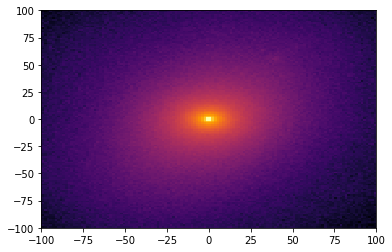

In [5]:
id = 372754
# Showing visual of subhalo
with h5py.File(f"subhalo_{id}.hdf5", "r") as file:
    print(file["99"].keys())
    print(file["99/dm"].keys())
    r = file["99/dm/Coordinates_centered"][:]
    dm_mass = 3.1e5/HubbleParam
    x = r[:,0]
    y = r[:,1]
    z = r[:,2]
    plt.hist2d(x,y,bins=128,range=[[-100,100],[-100,100]],weights=np.full(len(x), dm_mass),norm=mpl.colors.LogNorm(),cmap="inferno")

In [6]:
#The data file already have some useful values calculated
with h5py.File(f"subhalo_{id}.hdf5", "r") as file:
    print(file["99/dm"].keys())
# As it can be seen, the distance to the center, the centered frame of reference
# have been calculated beforehand, those values are calculated
# depending on how your particle data behaves

<KeysViewHDF5 ['Coordinates', 'Coordinates_centered', 'Distance_to_center', 'ParticleIDs', 'Potential', 'SubfindDMDensity', 'Velocities', 'count']>


# Obtaining the density profile
When talking about a density profile(potential), esentially we want the mass density in bigger and bigger shells until a certain max R
To calculate this it can be done by knowing only the mass of the particles and their distance to the center.

In [121]:
def density_calculation(R,weights=1.0,distrange=(-2,3),bins=100,surfacedens=False, scale='log'):
    """
    This function calculates the mass density of a set of particle, taking spherical shells
    --------------
    Parameters
    - R             : (np.array) Radii of the particles
    - weights       : (np.array or float) Either a float or an array, being the mass of the particles (default=1.0)
    - distrange     : (tuple) min R and max R (default=(1e-2,1e3))
    - bins          : (int) number of bins (default=100)
    - surfacedens   : (bool) whether to compute the density as surface density or not (default=False)
    - scale         : (str) either 'log' or 'linear'
    --------------
    Returns
    - rcentres      : (np.array) centers of the bins calculated
    - bin_length    : (float) the lenght(dR) of the bins calculated
    - densities     : (np.array) the mass densities calculated
    """
    # Calculate the bin_length or dR
    bin_length = (distrange[1]-distrange[0])/bins
    rcentres = np.zeros(bins)
    densities = np.zeros(bins)

    # In case of weights being a float, make it an array
    if isinstance(weights, float) is True:
        w = weights*np.full(R.size, 1)
    else:
        w = weights
    # Now begin the calculation of densities
    if scale in ['lin','linear']:
        for i in range(0,bins):
            # Compute the given rcentre for this bin
            rcentres[i] = distrange[0] + bin_length*(i+0.5)
            # Compute Rmin and Rmax of the given bin
            Rmin = distrange[0] + bin_length*(i)
            Rmax = distrange[0] + bin_length*(i+1)
            # Calculate either the volume or surface
            if surfacedens is True:
                shell = np.pi*(rcentres[i]**2)
            else:
                shell = (4/3)*np.pi*(Rmax**3-Rmin**3)
            # All particles in the bin
            inbinfilter = np.where((R > Rmin) & (R < Rmax))
            # Now we have the shell(volume or surface) and we have the Masses of the particles within the bin
            # Calculate the mass inside the bin
            mass_in_bin = np.nansum(w[inbinfilter])
            # Compute the mass density
            densities[i] = mass_in_bin/shell
    elif scale in ['log','logarithmic']:
        # First redefine R as logR, for readibility
        logR = R
        for i in range(0,bins):
            # Compute the given logrcentre for this bin
            rcentres[i] = distrange[0] + bin_length*(i+0.5)
            # Compute Rmin and Rmax of the given bin
            Rmin = 10**(distrange[0] + bin_length*(i))
            Rmax = 10**(distrange[0] + bin_length*(i+1))
            # Calculate either the volume or surface
            if surfacedens is True:
                # consider that rcentres is in log
                shell = np.pi*((10**rcentres[i])**2)
            else:
                shell = (4/3)*np.pi*(Rmax**3-Rmin**3)
            # All particles in the bin
            inbinfilter = np.where((logR >= (distrange[0] + bin_length*(i))) & (logR < (distrange[0] + bin_length*(i+1))))
            # Now we have the shell(volume or surface) and we have the Masses of the particles within the bin
            # Calculate the mass inside the bin
            mass_in_bin = np.nansum(w[inbinfilter])
            # Compute the mass density
            densities[i] = mass_in_bin/shell
    else:
        raise "scale must be 'log' or 'linear'"
    return (rcentres,bin_length,densities)

<KeysViewHDF5 ['dm', 'star']>
<KeysViewHDF5 ['Coordinates', 'Coordinates_centered', 'Distance_to_center', 'ParticleIDs', 'Potential', 'SubfindDMDensity', 'Velocities', 'count']>


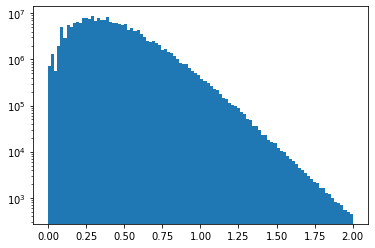

In [122]:
# In this case the R is in log scale, so if x=2 then R=10^2(kpc)
with h5py.File(f"subhalo_{id}.hdf5", "r") as file:
    print(file["99"].keys())
    print(file["99/dm"].keys())
    R = file["99/dm/Distance_to_center"][:]
    dm_mass = 3.1e5/HubbleParam
    rcentres,bin_length,densities = density_calculation(R,weights=dm_mass, distrange=(0,2),bins=100)
    plt.bar(rcentres, densities, width=bin_length)
    plt.yscale('log')

# Making an empirical model
WIP, Revise this correctly Marcos 7-7

In [19]:
def makemodel_empirical(rvals,dvals,pfile='',plabel = '',verbose=True):
    """make an EXP-compatible spherical basis function table

    inputs
    -------------
    rvals       : (array of floats) radius values to evaluate the density function
    pfile       : (string) the name of the output file. If '', will not print file
    plabel      : (string) comment string, printed to the top of the file
    verbose     : (boolean)

    outputs
    -------------
    R           : (array of floats) the radius values
    D           : (array of floats) the density
    M           : (array of floats) the mass enclosed
    P           : (array of floats) the potential

    """
    M = 1.
    R = np.nanmax(rvals)

    # query out the density values
    #dvals = D#func(rvals,*funcargs)
    #print(R.size,)

    # make the mass and potential arrays
    mvals = np.zeros(dvals.size)
    pvals = np.zeros(dvals.size)
    pwvals = np.zeros(dvals.size)

    # initialise the mass enclosed an potential energy
    mvals[0] = 1.e-15
    pwvals[0] = 0.

    # evaluate mass enclosed and potential energy by recursion
    for indx in range(1,dvals.size):
        mvals[indx] = mvals[indx-1] +\
          2.0*np.pi*(rvals[indx-1]*rvals[indx-1]*dvals[indx-1] +\
                 rvals[indx]*rvals[indx]*dvals[indx])*(rvals[indx] - rvals[indx-1]);
        pwvals[indx] = pwvals[indx-1] + \
          2.0*np.pi*(rvals[indx-1]*dvals[indx-1] + rvals[indx]*dvals[indx])*(rvals[indx] - rvals[indx-1]);

    # evaluate potential (see theory document)
    pvals = -mvals/(rvals+1.e-10) - (pwvals[dvals.size-1] - pwvals)

    # get the maximum mass and maximum radius
    M0 = mvals[dvals.size-1]
    R0 = rvals[dvals.size-1]

    # compute scaling factors
    Beta = (M/M0) * (R0/R);
    Gamma = np.sqrt((M0*R0)/(M*R)) * (R0/R);
    if verbose:
        print("! Scaling:  R=",R,"  M=",M)

    rfac = np.power(Beta,-0.25) * np.power(Gamma,-0.5);
    dfac = np.power(Beta,1.5) * Gamma;
    mfac = np.power(Beta,0.75) * np.power(Gamma,-0.5);
    pfac = Beta;

    if verbose:
        print(rfac,dfac,mfac,pfac)

    # save file if desired
    if pfile != '':
        f = open(pfile,'w')
        print('! ',plabel,file=f)
        print('! R    D    M    P',file=f)

        print(rvals.size,file=f)

        for indx in range(0,rvals.size):
            print('{0} {1} {2} {3}'.format( rfac*rvals[indx],\
              dfac*dvals[indx],\
              mfac*mvals[indx],\
              pfac*pvals[indx]),file=f)

        f.close()

    return rvals*rfac,dfac*dvals,mfac*mvals,pfac*pvals

In [19]:
id = 372754

with h5py.File(f"subhalo_{id}.hdf5", "r") as file:
    print(file["99"].keys())
    print(file["99/dm"].keys())
    R = file["99/dm/Distance_to_center"][:]
    dm_mass = 3.1e5/HubbleParam
    rcentres,bin_length,densities = density_calculation(R,weights=dm_mass, distrange=(0,2),bins=100)
    R,D,M,P = makemodel_empirical(10**rcentres,densities,pfile=f"{id}basis_empirical.txt")

<KeysViewHDF5 ['dm', 'star']>
<KeysViewHDF5 ['Coordinates', 'Coordinates_centered', 'Distance_to_center', 'ParticleIDs', 'Potential', 'SubfindDMDensity', 'Velocities', 'count']>
! Scaling:  R= 97.72372209558107   M= 1.0
1.0 5.7189640215320837e-11 5.7189640215320824e-11 5.718964021532083e-11


# Generating a basis for GSE
Since this is already done by me in test.ipynb, pretty much just follow that workflow

In [158]:
import pyEXP
# to generate the basis just use the configuration file as learnes
# again L stands for harmonic orders, n for radial orders
id = 372754

gseE_config = f"""
id         : sphereSL
parameters :
  numr     : 4000
  rmin     : 1.5
  rmax     : 100.0
  Lmax     : 6
  nmax     : 20
  modelname : {id}basis_empirical.txt
  cachename : {id}basis.empirical.cache
"""
subhaloE_basis = pyEXP.basis.Basis.factory(gseE_config)

---- SLGridSph::ReadH5Cache: successfully read basis cache <372754basis.empirical.cache>
SphericalSL::orthoTest: worst=0.00475019


In [159]:
basis = subhaloE_basis.getBasis()

In [160]:
with h5py.File(f"subhalo_{id}.hdf5", "r") as file:
    xpos = file['99/dm/Coordinates_centered'][:,0]
    ypos = file['99/dm/Coordinates_centered'][:,1]
    zpos = file['99/dm/Coordinates_centered'][:,2]
    mass = np.full(len(xpos),3.1e5/HubbleParam)
    subhaloE_coef = subhaloE_basis.createFromArray(mass,[xpos,ypos,zpos], time=0.0)

In [161]:
subhaloE_coef.getCoefs().real

array([ 6.82119667e+11, -1.34980861e+09, -6.36533040e+08,  6.57355623e+09,
       -1.08551666e+10,  6.52265594e+09, -1.33871076e+08, -1.67577270e+08,
       -1.65003805e+08, -8.40456748e+07, -1.17462708e+08, -4.77682379e+08,
        7.79961089e+08, -4.19511065e+08,  2.83954817e+08, -3.30056735e+07,
        8.91074381e+07,  8.46393625e+07, -1.54321108e+08,  3.81817256e+07,
       -6.77034095e+06, -9.42335127e+07,  4.88665396e+07,  1.41327340e+07,
       -9.27052586e+07,  3.97636253e+07,  2.26104085e+07,  5.23025525e+07])

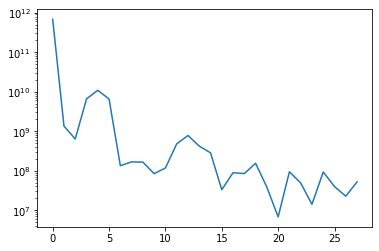

In [162]:
subhaloE_coef = subhaloE_basis.createFromArray(mass,[xpos,ypos,zpos], time=0.0)
plt.plot(np.abs(subhaloE_coef.getCoefs().real))
plt.yscale('log')

In [19]:
type(basis),len(basis),len(basis[0]),type(basis[0][0]),basis[0][0].keys()

(list, 7, 20, dict, dict_keys(['density', 'potential', 'rforce']))

In [20]:
import EXPtools

In [21]:
EXPtools.visuals.slice_fields(subhaloE_basis,subhaloE_coef)

AttributeError: 'pyEXP.coefs.SphStruct' object has no attribute 'getCoefStruct'

In [30]:
def slice_fields_single(basis, coefficients, time=0, 
                 projection='XY', proj_plane=0, npoints=300, 
                 grid_limits=(-300, 300), prop='dens', monopole_only=False):
    """
    Plots a slice projection of the fields of a simulation.

    Args:
    basis (obj): object containing the basis functions for the simulation
    coefficients (obj): object containing the coefficients for the simulation
    time (float): the time at which to plot the fields
    projection (str): the slice projection to plot. Can be 'XY', 'XZ', or 'YZ'.
    proj_plane (float, optional): the value of the coordinate that is held constant in the slice projection
    npoints (int, optional): the number of grid points in each dimension
    grid_limits (tuple, optional): the limits of the grid in the x and y dimensions, in the form (x_min, x_max)
    prop (str, optional): the property to return. Can be 'dens' (density), 'pot' (potential), or 'force' (force).
    monopole_only (bool, optional): whether to return the monopole component in the returned property value.

    Returns:
    array or list: the property specified by `prop`. If `prop` is 'force', a list of the x, y, and z components of the force is returned.
                    Also returns the grid used to compute slice fields. 
    """
    x = np.linspace(grid_limits[0], grid_limits[1], npoints)
    xgrid = np.meshgrid(x, x)
    xg = xgrid[0].flatten()
    yg = xgrid[1].flatten()

    
    if projection not in ['XY', 'XZ', 'YZ']:
        raise ValueError("Invalid projection specified. Possible values are 'XY', 'XZ', and 'YZ'.")

    N = len(xg)
    rho0 = np.zeros_like(xg)
    pot0 = np.zeros_like(xg)
    rho = np.zeros_like(xg)
    pot = np.zeros_like(xg)
    fx = np.zeros_like(xg)
    fy = np.zeros_like(xg)
    fz = np.zeros_like(xg)
    basis.set_coefs(coefficients)

    for k in range(0, N):
        if projection == 'XY':
            rho0[k], pot0[k], rho[k], pot[k], fx[k], fy[k], fz[k] = basis.getFields(xg[k], yg[k], proj_plane)
        elif projection == 'XZ':
            rho0[k], pot0[k], rho[k], pot[k], fx[k], fy[k], fz[k] = basis.getFields(xg[k], proj_plane, yg[k])
        elif projection == 'YZ':
            rho0[k], pot0[k], rho[k], pot[k], fx[k], fy[k], fz[k] = basis.getFields(proj_plane, xg[k], yg[k])
    
    dens = rho.reshape(npoints, npoints)
    pot = pot.reshape(npoints, npoints)
    dens0 = rho0.reshape(npoints, npoints)
    pot0 = pot0.reshape(npoints, npoints)
    fx = fx.reshape(npoints, npoints)
    fy = fy.reshape(npoints, npoints)
    fz = fz.reshape(npoints, npoints)

    if prop == 'dens':
        if monopole_only:
            return dens0
        return dens0, dens, xgrid

    if prop == 'pot':
        if monopole_only:
            return pot0
        return pot0, pot, xgrid

    if prop == 'force':
        return [fx, fy, fz], xgrid

In [31]:
field_dens = slice_fields_single(subhaloE_basis,subhaloE_coef, prop='dens')
field_pot = slice_fields_single(subhaloE_basis,subhaloE_coef, prop='pot')
field_force = slice_fields_single(subhaloE_basis,subhaloE_coef, prop='force')

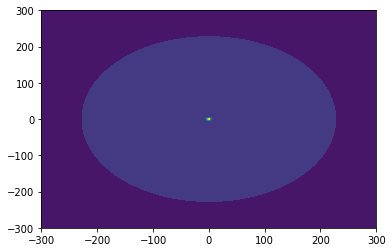

In [32]:
plt.contourf(field_dens[2][0],field_dens[2][1],field_dens[1])

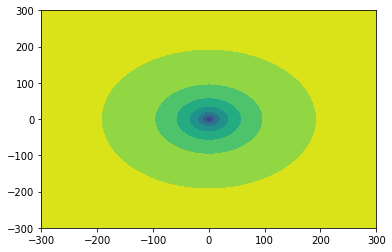

In [33]:
plt.contourf(field_pot[2][0],field_pot[2][1],field_pot[1])

/tmp/ipykernel_91/1869719678.py:5: RuntimeWarning: invalid value encountered in log10
  cont1 = plt.contour(x, y, np.log10(dens), colors='k')
/tmp/ipykernel_91/1869719678.py:7: RuntimeWarning: invalid value encountered in log10
  cont2 = plt.contourf(x, y, np.log10(dens))


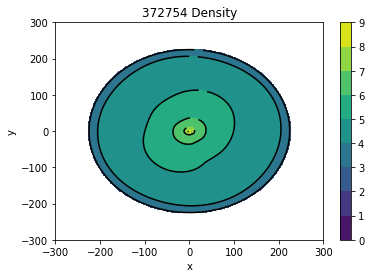

In [34]:
x = field_dens[2][0]
y = field_dens[2][1]
dens = field_dens[1]

cont1 = plt.contour(x, y, np.log10(dens), colors='k')
plt.clabel(cont1, fontsize=0, inline=True)
cont2 = plt.contourf(x, y, np.log10(dens))
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'{id} Density')
plt.show()

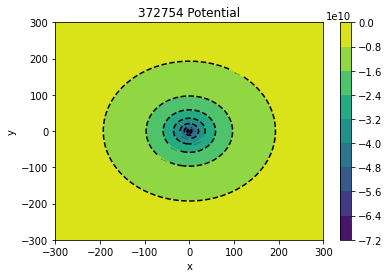

In [35]:
x = field_pot[2][0]
y = field_pot[2][1]
pot = field_pot[1]

cont1 = plt.contour(x, y, pot, colors='k')
plt.clabel(cont1, fontsize=0, inline=True)
cont2 = plt.contourf(x, y, pot)
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'{id} Potential')
plt.show()

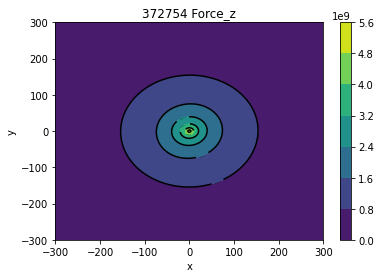

In [36]:
x = field_force[1][0]
y = field_force[1][1]
forcez = field_force[0][2]

cont1 = plt.contour(x, y, forcez, colors='k')
plt.clabel(cont1, fontsize=0, inline=True)
cont2 = plt.contourf(x, y, forcez)
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'{id} Force_z')
plt.show()

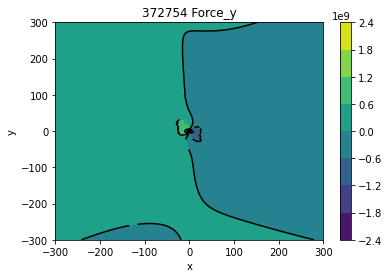

In [37]:
x = field_force[1][0]
y = field_force[1][1]
forcey = field_force[0][1]

cont1 = plt.contour(x, y, forcey, colors='k')
plt.clabel(cont1, fontsize=0, inline=True)
cont2 = plt.contourf(x, y, forcey)
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'{id} Force_y')
plt.show()

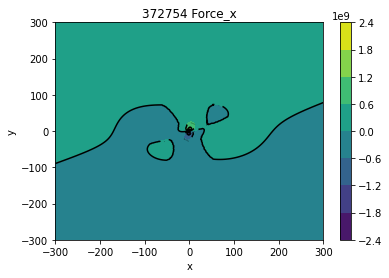

In [38]:
x = field_force[1][0]
y = field_force[1][1]
forcex = field_force[0][0]

cont1 = plt.contour(x, y, forcex, colors='k')
plt.clabel(cont1, fontsize=0, inline=True)
cont2 = plt.contourf(x, y, forcex)
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'{id} Force_x')
plt.show()

In [39]:
fields = {}
fields["dens"] = slice_fields_single(subhaloE_basis,subhaloE_coef, prop='dens')
fields["pot"] = slice_fields_single(subhaloE_basis,subhaloE_coef, prop='pot')
fields["force"] = slice_fields_single(subhaloE_basis,subhaloE_coef, prop='force')

<KeysViewHDF5 ['dm', 'star']>
<KeysViewHDF5 ['Coordinates', 'Coordinates_centered', 'Distance_to_center', 'ParticleIDs', 'Potential', 'SubfindDMDensity', 'Velocities', 'count']>


/tmp/ipykernel_91/683610360.py:44: RuntimeWarning: invalid value encountered in log10
  cont1 = axes[i,j].contour(x, y, np.log10(z), colors='k')
/tmp/ipykernel_91/683610360.py:45: RuntimeWarning: invalid value encountered in log10
  cont2 = axes[i,j].contourf(x, y, np.log10(z))


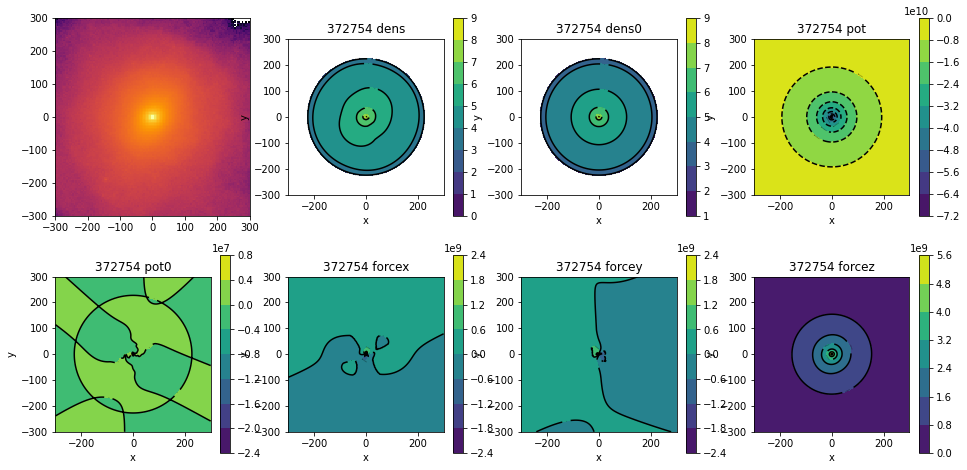

In [42]:
# Generacion de figura boni :3
fig, axes = plt.subplots(2,4,figsize=(16,8))
id = 372754
names = ["dens","dens0","pot","pot0","forcex","forcey","forcez"]

# Particle data
with h5py.File(f"subhalo_{id}.hdf5", "r") as file:
    print(file["99"].keys())
    print(file["99/dm"].keys())
    r = file["99/dm/Coordinates_centered"][:]
    dm_mass = 3.1e5/HubbleParam
    x = r[:,0]
    y = r[:,1]
    z = r[:,2]
    axes[0,0].hist2d(x,y,bins=128,range=[[-300,300],[-300,300]],weights=np.full(len(x), dm_mass),norm=mpl.colors.LogNorm(),cmap="inferno")

i,j = 0, 1

for number in range(8):
    name = names[number]

    if name in ["dens","pot"]:
        x = fields[name][2][0]
        y = fields[name][2][1]
        z = fields[name][1]
    if name in ["dens0","pot0"]:
        x = fields[name[:-1]][2][0]
        y = fields[name[:-1]][2][1]
        z = fields[name[:-1]][0]
    if name == "forcex":
        x = fields[name[:-1]][1][0]
        y = fields[name[:-1]][1][1]
        z = fields[name[:-1]][0][0]
    if name == "forcey":
        x = fields[name[:-1]][1][0]
        y = fields[name[:-1]][1][1]
        z = fields[name[:-1]][0][1]
    if name == "forcez":
        x = fields[name[:-1]][1][0]
        y = fields[name[:-1]][1][1]
        z = fields[name[:-1]][0][2]

    if name in ["dens","dens0"]:
        cont1 = axes[i,j].contour(x, y, np.log10(z), colors='k')
        cont2 = axes[i,j].contourf(x, y, np.log10(z))
    else:
        cont1 = axes[i,j].contour(x, y, z, colors='k')
        cont2 = axes[i,j].contourf(x, y, z)
    axes[i,j].clabel(cont1, fontsize=0, inline=True)
    plt.colorbar(cont2)
    axes[i,j].set_xlabel('x')
    axes[i,j].set_aspect('equal', adjustable='box')
    axes[i,j].set_ylabel('y')
    axes[i,j].set_title(f'{id} {names[number]}')
    j += 1
    if j > 3:
        i += 1
        j = 0
        if i > 1:
            break

plt.savefig(f"subhalo_{id}_fields.png")

# Fitting the density profile
Now it is neccesary to use some kind of smoothening, to obtain the representative 0th order
Last section used an empirical model, meaning that for every density value, we obtain the potential and the enclosed mass.
EXPtools provides a few

In [2]:
import h5py
import EXPtools
import pyEXP
import numpy as np
import matplotlib.pyplot as plt

In [3]:
id = 372754
# Obtained from the header file
HubbleParam  =  0.6774
Omega0  =  0.3089
OmegaLambda  =  0.6911
Redshift  =  2.220446049250313e-16
Time  =  0.9999999999999998 # Is also defined as the scale factor a, since z~0, a~1
with h5py.File(f"subhalo_{id}.hdf5", "r") as file:
    print(file['99/dm'].keys())
    pos = np.array(file['99/dm/Coordinates_centered'])
    radius = np.array(file['99/dm/Distance_to_center'])
    mass = np.full(pos.shape[0],3.1e5/HubbleParam)

<KeysViewHDF5 ['Coordinates', 'Coordinates_centered', 'Distance_to_center', 'ParticleIDs', 'Potential', 'SubfindDMDensity', 'Velocities', 'count']>


## Empirical fit

In [5]:
def empirical_density_profile(pos, mass, nbins=500, rmin=0, rmax=600, log_space=False):
    """
    Computes the number density radial profile assuming all particles have the same mass.
    Args:
        pos (ndarray): array of particle positions in cartesian coordinates with shape (n,3).
        mass (ndarray): array of particle masses with shape (n,).
        nbins (int, optional): number of bins in the radial profile. Default is 500.
        rmin (float, optional): minimum radius of the radial profile. Default is 0.
        rmax (float, optional): maximum radius of the radial profile. Default is 600.
        log_space (bool, optional): whether to use logarithmic binning. Default is False.
    Returns:
        tuple: a tuple containing the arrays of radius and density with shapes (nbins,) and (nbins,), respectively.
    Raises:
        ValueError: if pos and mass arrays have different lengths or if nbins is not a positive integer.
    """
    if len(pos) != len(mass):
        raise ValueError("pos and mass arrays must have the same length")
    if not isinstance(nbins, int) or nbins <= 0:
        raise ValueError("nbins must be a positive integer")

    # Compute radial distances
    r_p = np.sqrt(np.sum(pos**2, axis=1))

    # Compute bin edges and shell volumes
    if log_space:
        bins = np.logspace(np.log10(rmin), np.log10(rmax), nbins+1)
    else:
        bins = np.linspace(rmin, rmax, nbins+1)
    V_shells = (4/3) * np.pi * (bins[1:]**3 - bins[:-1]**3)

    # Compute density profile
    density, _ = np.histogram(r_p, bins=bins, weights=mass)
    density /= V_shells

    # Compute bin centers and return profile
    radius = 0.5 * (bins[1:] + bins[:-1])
    return radius, density

def makemodel_empirical(rvals,dvals,pfile='',plabel = '',verbose=True):
    """make an EXP-compatible spherical basis function table

    inputs
    -------------
    rvals       : (array of floats) radius values to evaluate the density function
    pfile       : (string) the name of the output file. If '', will not print file
    plabel      : (string) comment string, printed to the top of the file
    verbose     : (boolean)

    outputs
    -------------
    R           : (array of floats) the radius values
    D           : (array of floats) the density
    M           : (array of floats) the mass enclosed
    P           : (array of floats) the potential

    """
    M = 1.
    R = np.nanmax(rvals)

    # query out the density values
    #dvals = D#func(rvals,*funcargs)
    #print(R.size,)

    # make the mass and potential arrays
    mvals = np.zeros(dvals.size)
    pvals = np.zeros(dvals.size)
    pwvals = np.zeros(dvals.size)

    # initialise the mass enclosed an potential energy
    mvals[0] = 1.e-15
    pwvals[0] = 0.

    # evaluate mass enclosed and potential energy by recursion
    for indx in range(1,dvals.size):
        mvals[indx] = mvals[indx-1] +\
          2.0*np.pi*(rvals[indx-1]*rvals[indx-1]*dvals[indx-1] +\
                 rvals[indx]*rvals[indx]*dvals[indx])*(rvals[indx] - rvals[indx-1]);
        pwvals[indx] = pwvals[indx-1] + \
          2.0*np.pi*(rvals[indx-1]*dvals[indx-1] + rvals[indx]*dvals[indx])*(rvals[indx] - rvals[indx-1]);

    # evaluate potential (see theory document)
    pvals = -mvals/(rvals+1.e-10) - (pwvals[dvals.size-1] - pwvals)

    # get the maximum mass and maximum radius
    M0 = mvals[dvals.size-1]
    R0 = rvals[dvals.size-1]

    # compute scaling factors
    Beta = (M/M0) * (R0/R);
    Gamma = np.sqrt((M0*R0)/(M*R)) * (R0/R);
    if verbose:
        print("! Scaling:  R=",R,"  M=",M)

    rfac = np.power(Beta,-0.25) * np.power(Gamma,-0.5);
    dfac = np.power(Beta,1.5) * Gamma;
    mfac = np.power(Beta,0.75) * np.power(Gamma,-0.5);
    pfac = Beta;

    if verbose:
        print(rfac,dfac,mfac,pfac)

    # save file if desired
    if pfile != '':
        f = open(pfile,'w')
        print('! ',plabel,file=f)
        print('! R    D    M    P',file=f)

        print(rvals.size,file=f)

        for indx in range(0,rvals.size):
            print('{0} {1} {2} {3}'.format( rfac*rvals[indx],\
              dfac*dvals[indx],\
              mfac*mvals[indx],\
              pfac*pvals[indx]),file=f)

        f.close()

    return rvals*rfac,dfac*dvals,mfac*mvals,pfac*pvals

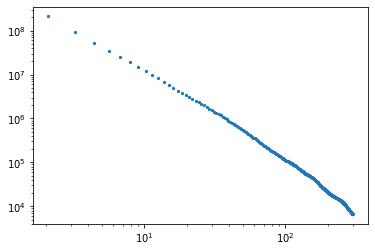

In [19]:
# Obtaining empirical density profile
bins_q = 256
e_R,e_dens = empirical_density_profile(pos,mass,log_space=False,rmin=1.5,rmax=300,nbins=bins_q)
plt.scatter(e_R,e_dens,s=5)
plt.yscale('log')
plt.xscale('log')

In [ ]:
R,D,M,P = makemodel_empirical(e_R,e_dens,pfile=f"{id}basis_empirical_EXPtools.txt")
gseE_configs = f"""
id         : sphereSL
parameters :
  numr     : 4000
  rmin     : 1.5
  rmax     : 1000.0
  Lmax     : 6
  nmax     : 20
  modelname : {id}basis_empirical_EXPtools.txt
  cachename : {id}basis.empirical_EXPtools.cache
"""
subhaloE_basis = pyEXP.basis.Basis.factory(gseE_configs)

In [6]:
basis = subhaloE_basis.getBasis()
subhaloE_coefs = subhaloE_basis.createFromArray(mass,[pos[:,0],pos[:,1],pos[:,2]], time=0.0)

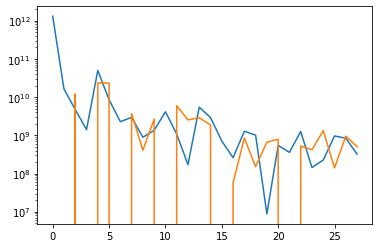

In [7]:
coefs = subhaloE_coefs.getCoefs()
plt.plot(np.abs(coefs.real))
plt.plot(np.abs(coefs.imag))
plt.yscale('log')

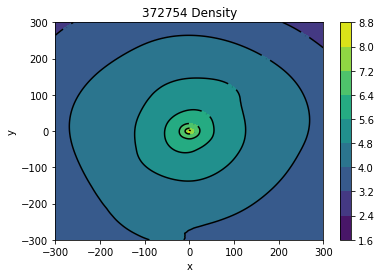

In [8]:
dens0, dens, xgrid = EXPtools.visuals.slice_fields(subhaloE_basis,subhaloE_coefs,prop="dens")

x = xgrid[0]
y = xgrid[1]

cont1 = plt.contour(x, y, np.log10(dens), colors='k')
plt.clabel(cont1, fontsize=0, inline=True)
cont2 = plt.contourf(x, y, np.log10(dens))
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'{id} Density')
plt.show()

IndexError: list index out of range

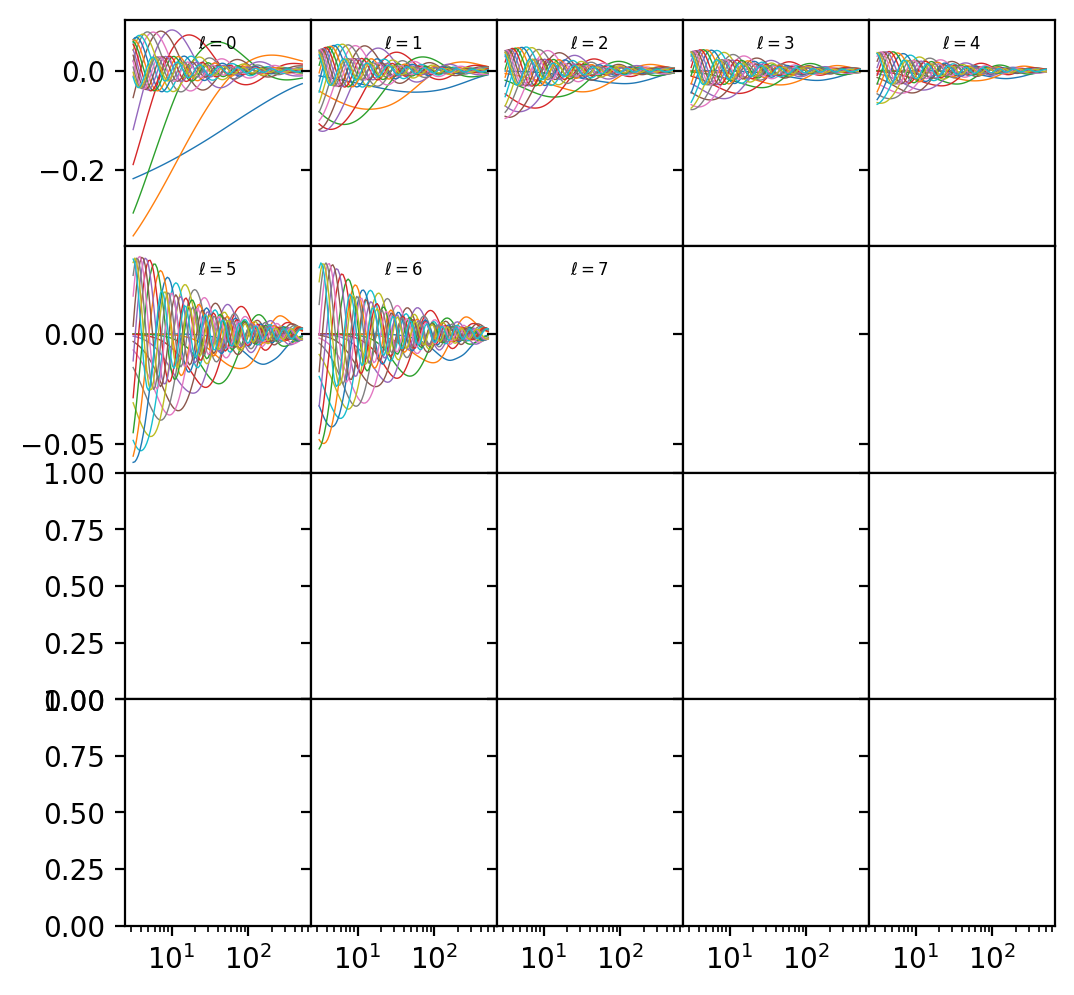

In [9]:
EXPtools.visuals.visualize.make_basis_plot(subhaloE_basis, 5, 5)

## Hernquist fit

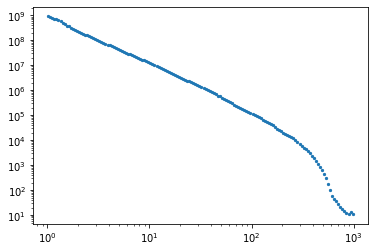

In [21]:
# We need to first obtain the fit according to the density obtained
# Obtaining empirical density profile
e_R,e_dens = empirical_density_profile(pos,mass,log_space=True,rmin=1,rmax=1000,nbins=bins_q)
plt.scatter(e_R,e_dens,s=5)
plt.yscale('log')
plt.xscale('log')

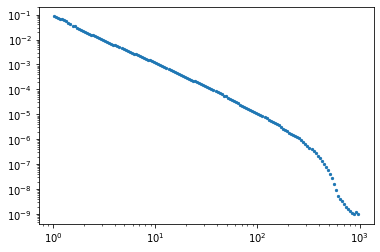

In [25]:
# We need to first obtain the fit according to the density obtained
# Obtaining empirical density profile
e_R,e_dens = empirical_density_profile(pos,mass,log_space=True,rmin=1,rmax=1000,nbins=bins_q)
plt.scatter(e_R,e_dens/np.sum(e_dens),s=5)
plt.yscale('log')
plt.xscale('log')

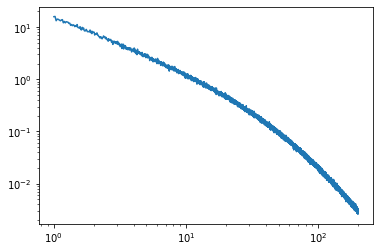

In [26]:
# Modeled hernquist with a=100
R = np.linspace(1,200,10000)
hern_dens = EXPtools.basis_builder.makemodel.hernquist_halo(R,a=1e2)
hern_dens += [hern_dens[_]*np.random.normal(0,0.05) for _ in range(len(hern_dens))]
plt.plot(R,hern_dens)
plt.yscale('log')
plt.xscale('log')

a_fit =  [99.92898145]


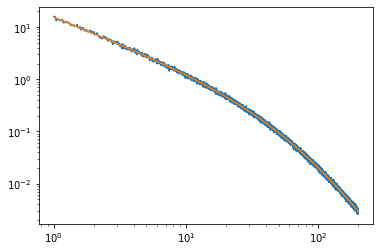

In [27]:
# Fitting a to the modeled hernquist a=100
import scipy.optimize
a_fit, cov_fit = scipy.optimize.curve_fit(EXPtools.basis_builder.makemodel.hernquist_halo,xdata=R,ydata=hern_dens)
hern_fit = EXPtools.basis_builder.makemodel.hernquist_halo(R,a=a_fit)
print("a_fit = ",a_fit)
plt.plot(R,hern_dens)
plt.plot(R,hern_fit)
plt.yscale('log')
plt.xscale('log')

a_fit =  [2.01378504] |var =  [[3.89430201e-05]]


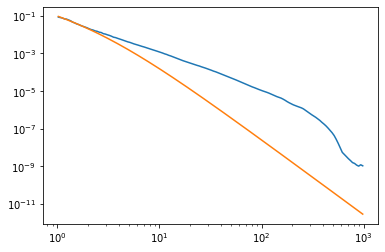

In [28]:
# Fitting the empirical density
import scipy.optimize
total_dens = np.sum(e_dens)
a_fit, cov_fit = scipy.optimize.curve_fit(EXPtools.basis_builder.makemodel.hernquist_halo,xdata=e_R,ydata=e_dens/total_dens)
hern_fit = EXPtools.basis_builder.makemodel.hernquist_halo(e_R,a=a_fit)
print("a_fit = ",a_fit, "|var = ", cov_fit)
plt.plot(e_R,e_dens/total_dens)
plt.plot(e_R,hern_fit)
plt.yscale('log')
plt.xscale('log')

In [29]:
R,D,M,P = makemodel_empirical(e_R,hern_fit,pfile=f"{id}basis_hern_EXPtools.txt")
gseE_config = f"""
id         : sphereSL
parameters :
  numr     : 4000
  rmin     : 1.5
  rmax     : 900.0
  Lmax     : 6
  nmax     : 20
  modelname : {id}basis_hern_EXPtools.txt
  cachename : {id}basis.hern_EXPtools.cache
"""
subhaloE_basis = pyEXP.basis.Basis.factory(gseE_config)

! Scaling:  R= 977.4962930107179   M= 1.0
0.9999999999999998 0.13872412988359775 0.1387241298835977 0.13872412988359772
---- SLGridSph::WriteH5Cache: wrote <372754basis.hern_EXPtools.cache>
SphericalSL::orthoTest: worst=0.0014156


---- SLGridSph::ReadH5Cache: error reading <372754basis.hern_EXPtools.cache>
---- SLGridSph::ReadH5Cache: HDF5 error is <Unable to open file 372754basis.hern_EXPtools.cache (File accessibility) Unable to open file>


In [30]:
basis = subhaloE_basis.getBasis()
subhaloE_coefs = subhaloE_basis.createFromArray(mass,[pos[:,0],pos[:,1],pos[:,2]], time=0.0)

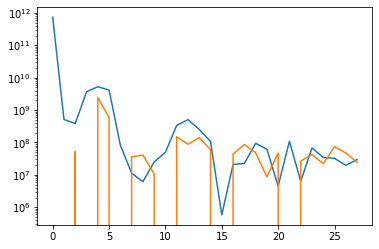

In [31]:
coefs = subhaloE_coefs.getCoefs()
plt.plot(np.abs(coefs.real))
plt.plot(np.abs(coefs.imag))
plt.yscale('log')

/tmp/ipykernel_147/331482539.py:6: RuntimeWarning: invalid value encountered in log10
  cont1 = plt.contour(x, y, np.log10(dens), colors='k')
/tmp/ipykernel_147/331482539.py:8: RuntimeWarning: invalid value encountered in log10
  cont2 = plt.contourf(x, y, np.log10(dens))


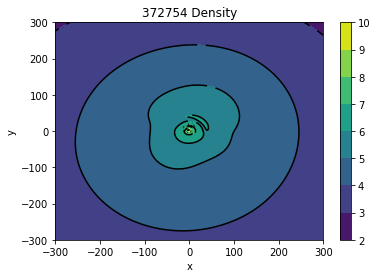

In [32]:
dens0, dens, xgrid = EXPtools.visuals.slice_fields(subhaloE_basis,subhaloE_coefs,prop="dens")

x = xgrid[0]
y = xgrid[1]

cont1 = plt.contour(x, y, np.log10(dens), colors='k')
plt.clabel(cont1, fontsize=0, inline=True)
cont2 = plt.contourf(x, y, np.log10(dens))
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'{id} Density')
plt.show()

## NFW fit

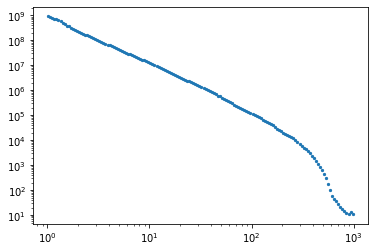

In [176]:
# We need to first obtain the fit according to the density obtained
# Obtaining empirical density profile
e_R,e_dens = empirical_density_profile(pos,mass,log_space=True,rmin=1,rmax=1000,nbins=bins_q)
plt.scatter(e_R,e_dens,s=5)
plt.yscale('log')
plt.xscale('log')

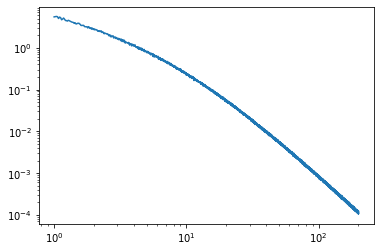

In [177]:
def nfw_halo(R, rs=1.,rc=0.):
    ra = R/rs
    dens = 1./(((ra+rc/rs)**1)*((1+ra)**2))
    return dens
# Noisy modeled NFW with 
R = np.linspace(1,200,10000)
nfw_dens = nfw_halo(R, rs=10.,rc=0.5)
nfw_dens += [nfw_dens[_]*np.random.normal(0,0.03) for _ in range(len(nfw_dens))]
plt.plot(R,nfw_dens)
plt.yscale('log')
plt.xscale('log')

rs_fit =  9.908457974391823 | rc_fit =  0.46233493622127686


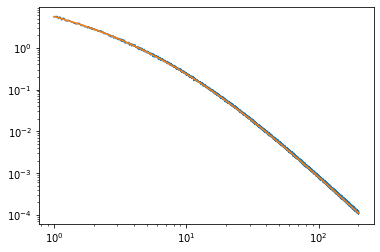

In [181]:
# Fitting a to the modeled hernquist a=100
import scipy.optimize
(rs_fit,rc_fit), _ = scipy.optimize.curve_fit(nfw_halo,xdata=R,ydata=nfw_dens)
nfw_fit =  nfw_halo(R, rs=rs_fit,rc=rc_fit)
print("rs_fit = ",rs_fit,"|","rc_fit = ",rc_fit)
plt.plot(R,nfw_dens)
plt.plot(R,nfw_fit)
plt.yscale('log')
plt.xscale('log')

rs_fit =  6.325899789214367 | rc_fit =  -0.5418503563574893


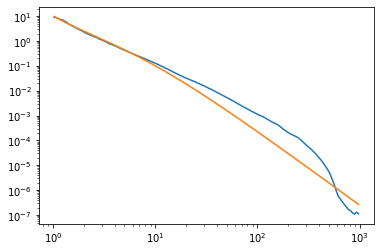

In [182]:
# Fitting a to the modeled hernquist a=100
import scipy.optimize
total_dens = 1e8
(rs_fit,rc_fit), _ = scipy.optimize.curve_fit(nfw_halo,xdata=e_R,ydata=e_dens/total_dens)
nfw_fit =  nfw_halo(e_R, rs=rs_fit,rc=rc_fit)
print("rs_fit = ",rs_fit,"|","rc_fit = ",rc_fit)
plt.plot(e_R,e_dens/total_dens)
plt.plot(e_R,nfw_fit)
plt.yscale('log')
plt.xscale('log')

In [34]:
EXPtools.basis_builder.basis_utils.makebasis?

Signature:
EXPtools.basis_builder.basis_utils.makebasis(
    pos,
    mass,
    basis_model,
    config=None,
    basis_id='sphereSL',
    time=0,
    numr=500,
    rmin=0.61,
    rmax=599,
    lmax=4,
    nmax=20,
    scale=1,
    norm_mass_coef=True,
    modelname='dens_table.txt',
    cachename='.slgrid_sph_cache',
    add_coef=False,
    coef_file='',
)
Docstring:
Create a BFE expansion for a given set of particle positions and masses.

Parameters:
pos (numpy.ndarray): The positions of particles. Each row represents one particle, 
                     and each column represents the coordinate of that particle.
mass (numpy.ndarray): The masses of particles. The length of this array should be the same 
                      as the number of particles.
basismodel ():
config (pyEXP.config.Config, optional): A configuration object that specifies the basis set. 
                                         If not provided, an empirical density profile will be computed 
                      

## Using basisutils

In [85]:
# makebasis por defecto normaliza por la masa total al crear los coeficientes
basis, coefs = EXPtools.basis_builder.basis_utils.makebasis(pos,mass,'Hernquist',lmax=6,nmax=20,
                                             modelname='hernq_model.txt',cachename='hernq_halo.cache',coef_file='hernq_halo.h5',
                                             nbins=4000, rmin=1.5, rmax=300
                                            )

-> File model not found so we are computing one 

-> Computing analytical Hernquist model
! Scaling:  R= 300.0000000000001   M= 4863113330380.946
1.0 1222022535548.7642 1222022535548.7642 1222022535548.7644
-> Model computed: rmin=1.5, rmax=300.0000000000001, numr=4001
No config file provided.
Computing empirical density
---- SLGridSph::WriteH5Cache: wrote <hernq_halo.cache>
SphericalSL::orthoTest: worst=7.214204e-05
------------------------------------------------------------
Cache parameters for SLGridSph: hernq_halo.cache
------------------------------------------------------------
model               : hernq_model.txt
lmax                : 6
nmax                : 20
numr                : 4001
cmap                : 1
rmin                : 1.5
rmax                : 300
rmapping            : 1
diverge             : 0
dfac                : 1
------------------------------------------------------------


---- SLGridSph::ReadH5Cache: error reading <hernq_halo.cache>
---- SLGridSph::ReadH5Cache: HDF5 error is <Unable to open file hernq_halo.cache (File accessibility) Unable to open file>


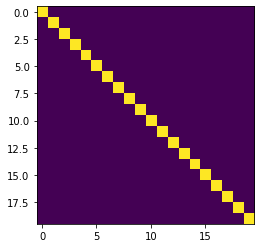

In [4]:
# check orthogonal basis
plt.imshow(basis.orthoCheck()[0])

In [5]:
read_model = np.loadtxt('hernq_model.txt', skiprows=3)

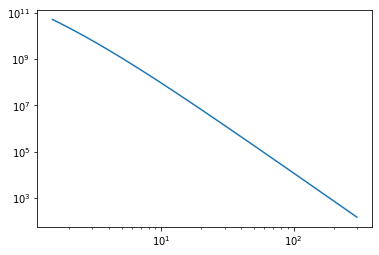

In [6]:
plt.plot(read_model[:,0],read_model[:,1])
plt.xscale('log')
plt.yscale('log')

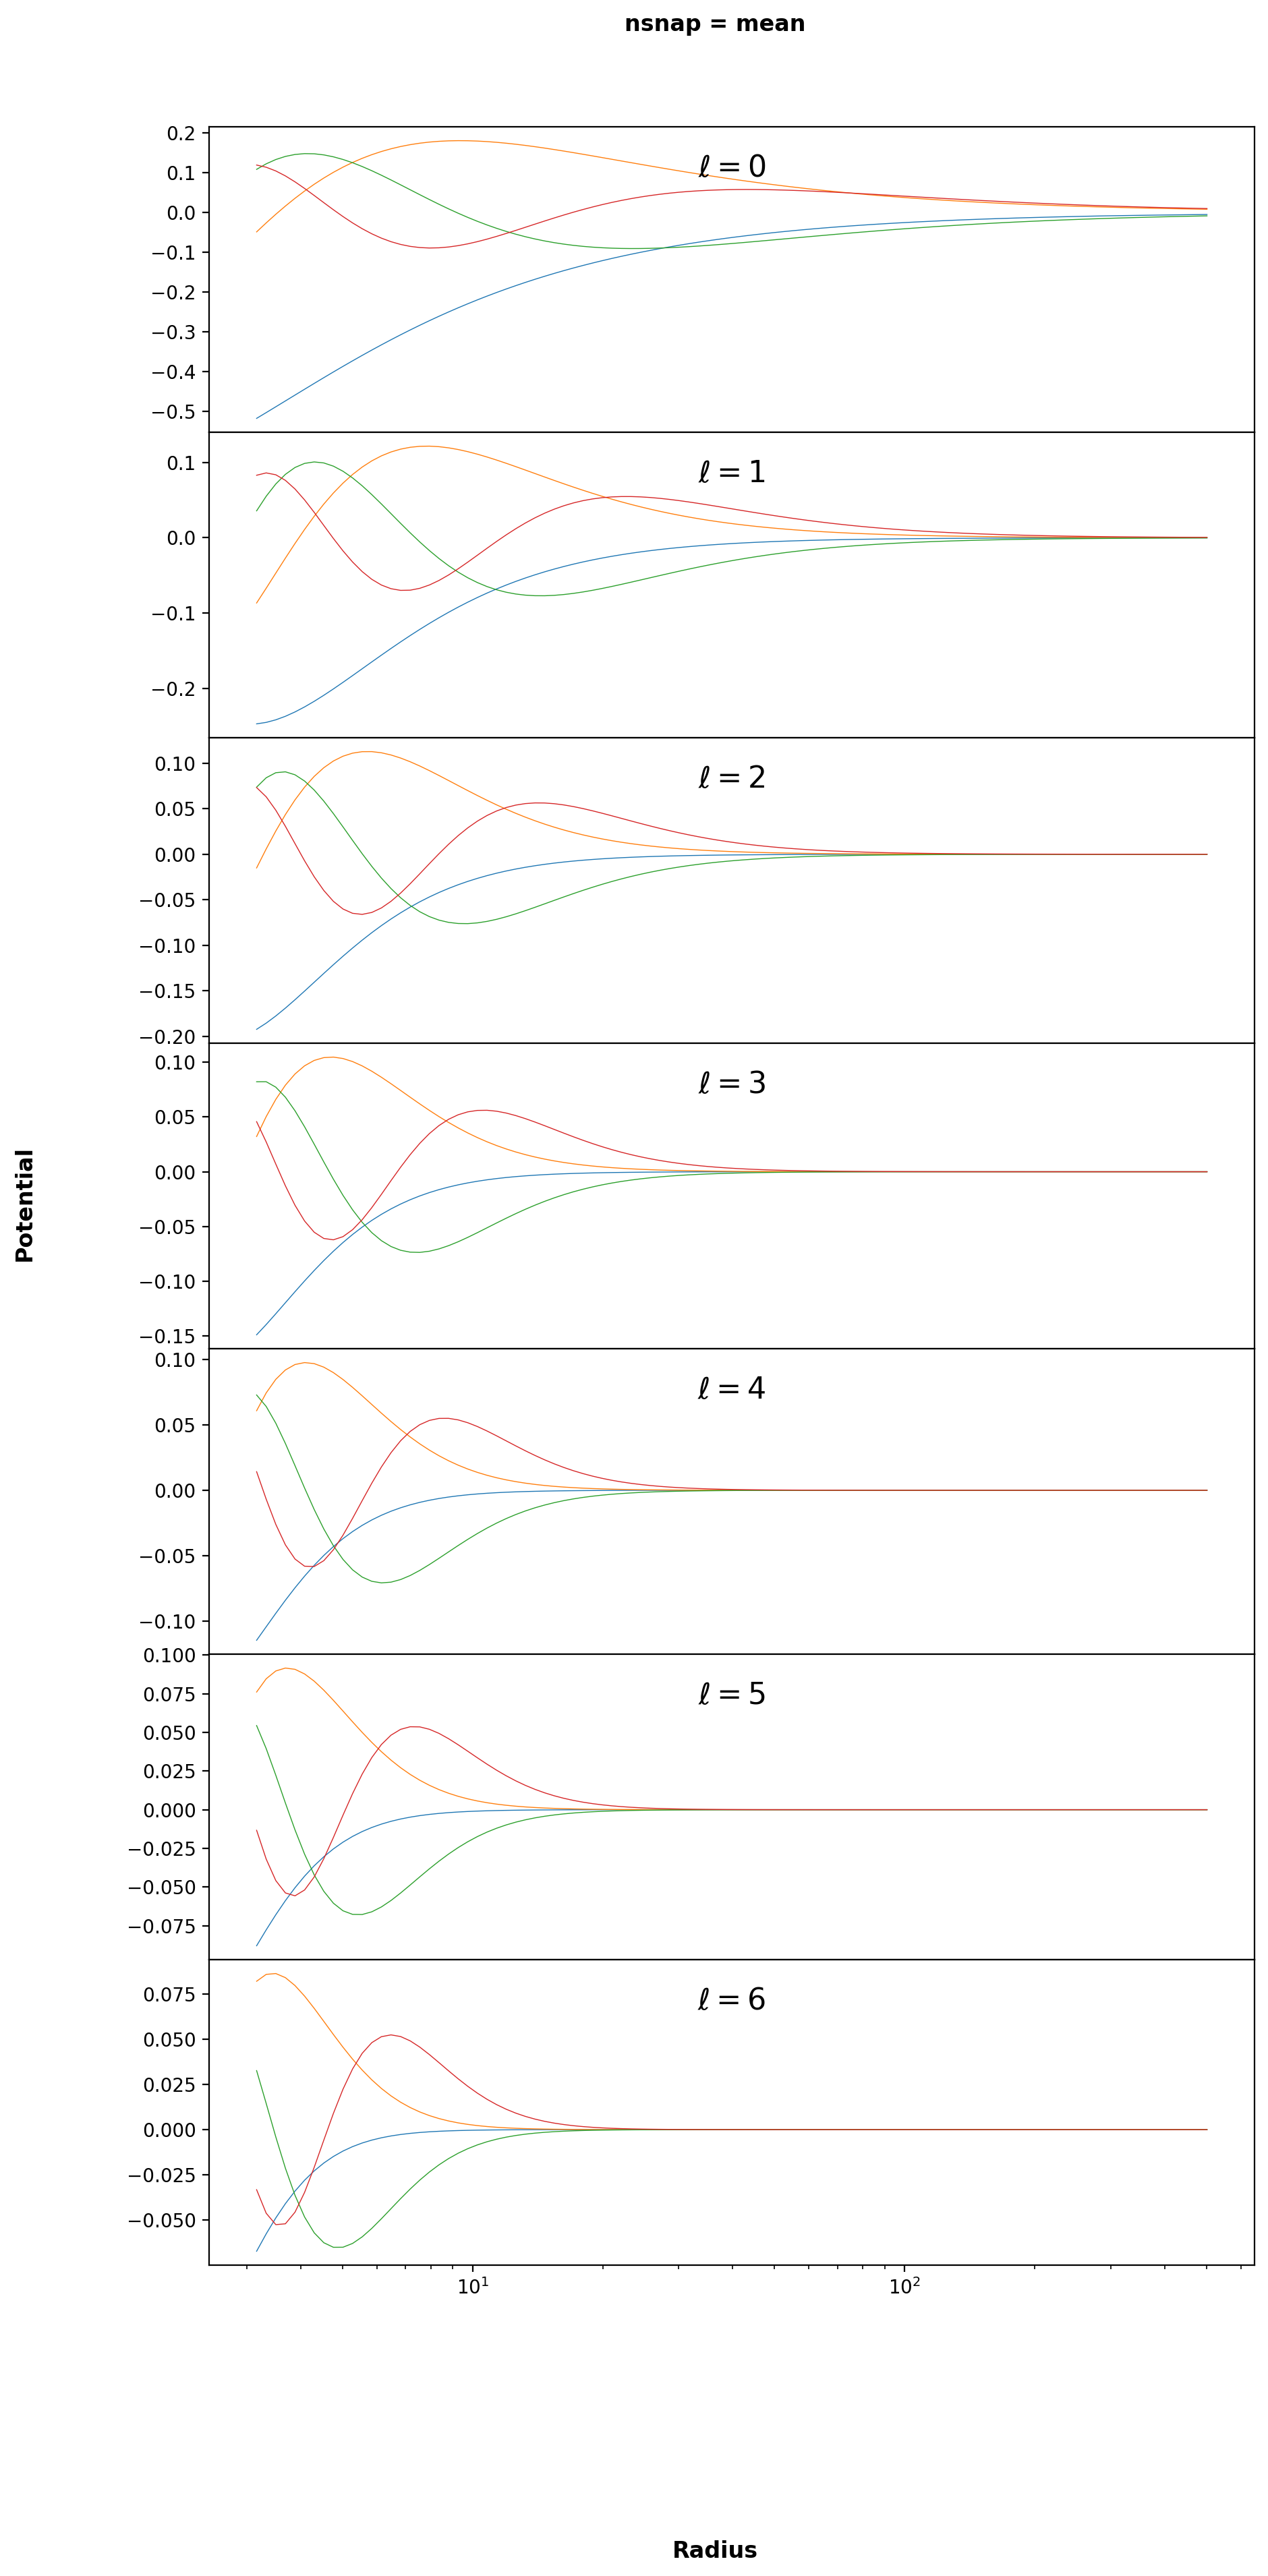

In [55]:
EXPtools.visuals.visualize.make_basis_plot(basis, lmax=7, nmax=4)

In [8]:
len(basis.getBasis(0.5, 2.7, 100))

7

/tmp/ipykernel_2729/2843016991.py:6: RuntimeWarning: invalid value encountered in log10
  cont1 = plt.contour(x, y, np.log10(dens), colors='k')
/tmp/ipykernel_2729/2843016991.py:8: RuntimeWarning: invalid value encountered in log10
  cont2 = plt.contourf(x, y, np.log10(dens))


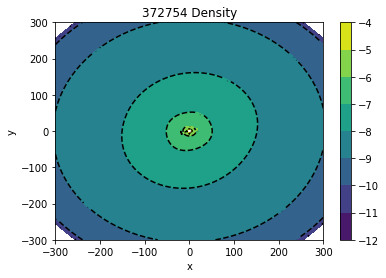

In [31]:
field_dens = EXPtools.visuals.visualize.slice_fields(basis, coefs, prop='dens')
x = field_dens[2][0]
y = field_dens[2][1]
dens = field_dens[1]

cont1 = plt.contour(x, y, np.log10(dens), colors='k')
plt.clabel(cont1, fontsize=0, inline=True)
cont2 = plt.contourf(x, y, np.log10(dens))
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'{id} Density')
plt.show()

/tmp/ipykernel_2729/3681496511.py:8: RuntimeWarning: invalid value encountered in log10
  cont1 = plt.contour(x, y, np.log10(dens), colors='k')
/tmp/ipykernel_2729/3681496511.py:10: RuntimeWarning: invalid value encountered in log10
  cont2 = plt.contourf(x, y, np.log10(dens))


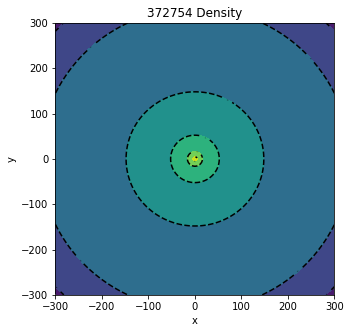

In [119]:
field_dens = EXPtools.visuals.visualize.slice_fields(basis, coefs, prop='dens')
x = field_dens[2][0]
y = field_dens[2][1]
dens = field_dens[0]

fig,ax = plt.subplots(1,1,figsize=(5,5))

cont1 = plt.contour(x, y, np.log10(dens), colors='k')
plt.clabel(cont1, fontsize=0, inline=True)
cont2 = plt.contourf(x, y, np.log10(dens))
#plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'{id} Density')
plt.show()

## Test area, for non-normalization

In [8]:
coefstruct = coefs.getCoefStruct(time=0.0)

In [9]:
coefstruct.getCoefs()

array([ 1.24479469e-01+0.00000000e+00j, -5.72561209e-05+0.00000000e+00j,
       -7.02004408e-05-2.06969684e-05j,  5.97990790e-04+0.00000000e+00j,
       -8.57724067e-04-3.84600374e-04j,  6.75956426e-04+7.29775219e-05j,
       -9.65815214e-06+0.00000000e+00j,  3.56819638e-06+8.16591190e-06j,
        5.78666912e-06+3.49601169e-06j, -6.85464701e-08+1.46182328e-07j,
       -9.24997816e-06+0.00000000e+00j, -6.11736793e-05-2.48573874e-05j,
        8.38644856e-05+1.35677619e-05j, -4.08009263e-05-2.08832927e-05j,
        1.39788602e-05+1.45314744e-05j, -1.48159098e-07+0.00000000e+00j,
       -8.70681458e-06+1.16328931e-05j, -9.48784362e-06-1.31278556e-05j,
       -1.28965320e-05+1.04378506e-05j,  7.80489840e-06+1.32404467e-06j,
       -1.99965931e-06+7.66764460e-06j, -2.11337015e-05+0.00000000e+00j,
       -1.29984359e-06+9.00278752e-06j,  1.40605280e-05+5.63882689e-06j,
       -2.04564395e-06-1.39352707e-06j,  4.72376939e-06+1.42362766e-05j,
        5.67630310e-07-7.13922841e-06j,  8.71164521

In [34]:
# Notar que en este caso no se normaliza por la masa total
coefs_fix = basis.createFromArray(mass=mass/np.sum(mass),
                                  pos=pos.T,
                                  time=0.0)

In [35]:
coefs_fix.getCoefs()

array([ 1.24479469e-01+0.00000000e+00j, -5.72561209e-05+0.00000000e+00j,
       -7.02004408e-05-2.06969684e-05j,  5.97990790e-04+0.00000000e+00j,
       -8.57724067e-04-3.84600374e-04j,  6.75956426e-04+7.29775219e-05j,
       -9.65815214e-06+0.00000000e+00j,  3.56819638e-06+8.16591190e-06j,
        5.78666912e-06+3.49601169e-06j, -6.85464701e-08+1.46182328e-07j,
       -9.24997816e-06+0.00000000e+00j, -6.11736793e-05-2.48573874e-05j,
        8.38644856e-05+1.35677619e-05j, -4.08009263e-05-2.08832927e-05j,
        1.39788602e-05+1.45314744e-05j, -1.48159098e-07+0.00000000e+00j,
       -8.70681458e-06+1.16328931e-05j, -9.48784362e-06-1.31278556e-05j,
       -1.28965320e-05+1.04378506e-05j,  7.80489840e-06+1.32404467e-06j,
       -1.99965931e-06+7.66764460e-06j, -2.11337015e-05+0.00000000e+00j,
       -1.29984359e-06+9.00278752e-06j,  1.40605280e-05+5.63882689e-06j,
       -2.04564395e-06-1.39352707e-06j,  4.72376939e-06+1.42362766e-05j,
        5.67630310e-07-7.13922841e-06j,  8.71164521

/tmp/ipykernel_2729/3207103999.py:6: RuntimeWarning: invalid value encountered in log10
  cont1 = plt.contour(x, y, np.log10(dens), colors='k')
/tmp/ipykernel_2729/3207103999.py:8: RuntimeWarning: invalid value encountered in log10
  cont2 = plt.contourf(x, y, np.log10(dens))


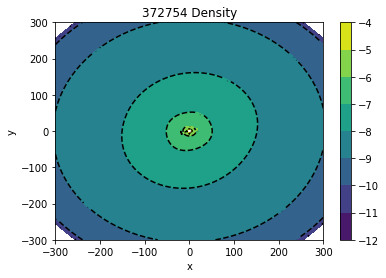

In [36]:
field_dens = EXPtools.visuals.visualize.slice_fields(basis, coefs_fix, prop='dens')
x = field_dens[2][0]
y = field_dens[2][1]
dens = field_dens[1]

cont1 = plt.contour(x, y, np.log10(dens), colors='k')
plt.clabel(cont1, fontsize=0, inline=True)
cont2 = plt.contourf(x, y, np.log10(dens))
plt.colorbar(cont2)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'{id} Density')
plt.show()

/tmp/ipykernel_2729/3220036821.py:20: RuntimeWarning: invalid value encountered in log10
  cont1 = axes[0].contour(x, y, np.log10(dens_norm), colors='k')
/tmp/ipykernel_2729/3220036821.py:21: RuntimeWarning: invalid value encountered in log10
  cont2 = axes[0].contourf(x, y, np.log10(dens_norm))
/tmp/ipykernel_2729/3220036821.py:25: RuntimeWarning: invalid value encountered in log10
  cont1 = axes[1].contour(x, y, np.log10(dens_nonorm), colors='k')
/tmp/ipykernel_2729/3220036821.py:26: RuntimeWarning: invalid value encountered in log10
  cont2 = axes[1].contourf(x, y, np.log10(dens_nonorm))


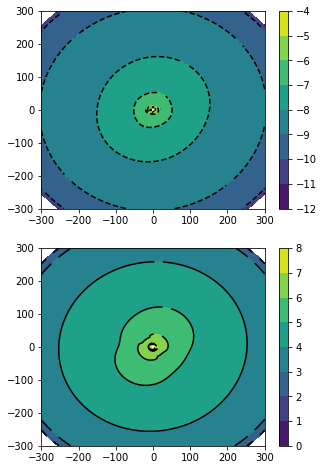

In [54]:
coefs_normalized = basis.createFromArray(mass=mass/np.sum(mass),
                                  pos=pos.T,
                                  time=0.0)
coefs_nonnormalized = basis.createFromArray(mass=mass,
                                  pos=pos.T,
                                  time=0.0)

field_dens_norm = EXPtools.visuals.visualize.slice_fields(basis, coefs_normalized, prop='dens')
x_norm = field_dens[2][0]
y_norm = field_dens[2][1]
dens_norm = field_dens[1]

field_dens_nonorm = EXPtools.visuals.visualize.slice_fields(basis, coefs_nonnormalized, prop='dens')
x_nonorm = field_dens[2][0]
y_nonorm = field_dens[2][1]
dens_nonorm = field_dens[1]

fig,axes = plt.subplots(2,1,figsize=(5,8))

cont1 = axes[0].contour(x, y, np.log10(dens_norm), colors='k')
cont2 = axes[0].contourf(x, y, np.log10(dens_norm))
axes[0].clabel(cont1, fontsize=0, inline=True)
plt.colorbar(cont2)

cont1 = axes[1].contour(x, y, np.log10(dens_nonorm), colors='k')
cont2 = axes[1].contourf(x, y, np.log10(dens_nonorm))
axes[1].clabel(cont1, fontsize=0, inline=True)
plt.colorbar(cont2)

/tmp/ipykernel_2729/2506867813.py:13: RuntimeWarning: invalid value encountered in log10
  cont1 = axes[0].contour(x, y, np.log10(dens_norm), colors='k')
/tmp/ipykernel_2729/2506867813.py:14: RuntimeWarning: invalid value encountered in log10
  cont2 = axes[0].contourf(x, y, np.log10(dens_norm))
/tmp/ipykernel_2729/2506867813.py:18: RuntimeWarning: invalid value encountered in log10
  cont1 = axes[1].contour(x, y, np.log10(dens_nonorm), colors='k')
/tmp/ipykernel_2729/2506867813.py:19: RuntimeWarning: invalid value encountered in log10
  cont2 = axes[1].contourf(x, y, np.log10(dens_nonorm))


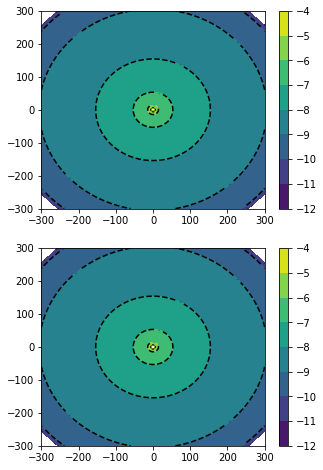

In [59]:
field_dens_norm = EXPtools.visuals.visualize.slice_fields(basis, coefs_normalized, prop='dens')
x_norm = field_dens[2][0]
y_norm = field_dens[2][1]
dens_norm = field_dens[0]

field_dens_nonorm = EXPtools.visuals.visualize.slice_fields(basis, coefs_nonnormalized, prop='dens')
x_nonorm = field_dens[2][0]
y_nonorm = field_dens[2][1]
dens_nonorm = field_dens[0]

fig,axes = plt.subplots(2,1,figsize=(5,8))

cont1 = axes[0].contour(x, y, np.log10(dens_norm), colors='k')
cont2 = axes[0].contourf(x, y, np.log10(dens_norm))
axes[0].clabel(cont1, fontsize=0, inline=True)
plt.colorbar(cont2)

cont1 = axes[1].contour(x, y, np.log10(dens_nonorm), colors='k')
cont2 = axes[1].contourf(x, y, np.log10(dens_nonorm))
axes[1].clabel(cont1, fontsize=0, inline=True)
plt.colorbar(cont2)

## using makebasis, other strategies 7u7r

In [37]:
pos.T[:,0:3],pos[0:3],[pos[0:3,0],pos[0:3,1],pos[0:3,2]]

(array([[-0.11921653, -0.06802396,  0.08446022],
        [-0.09900432,  0.04788647,  0.23606988],
        [ 0.0413737 ,  0.35164757,  0.25285447]]),
 array([[-0.11921653, -0.09900432,  0.0413737 ],
        [-0.06802396,  0.04788647,  0.35164757],
        [ 0.08446022,  0.23606988,  0.25285447]]),
 [array([-0.11921653, -0.06802396,  0.08446022]),
  array([-0.09900432,  0.04788647,  0.23606988]),
  array([0.0413737 , 0.35164757, 0.25285447])])

In [23]:
pos.shape

(10626687, 3)

In [24]:
mass.shape

(10626687,)

In [27]:
pos[0:5],mass[0:5]

(array([[-0.11921653, -0.09900432,  0.0413737 ],
        [-0.06802396,  0.04788647,  0.35164757],
        [ 0.08446022,  0.23606988,  0.25285447],
        [-0.24171911, -0.16270979,  0.01886733],
        [ 0.19743108,  0.20786581,  0.5299721 ]]),
 array([457632.12282256, 457632.12282256, 457632.12282256, 457632.12282256,
        457632.12282256]))

In [22]:
# >>>pos.shape
# (10626687, 3)
# >>>mass.shape
# (10626687,)
# >>>pos[0:5],mass[0:5]
# (array([[-0.11921653, -0.09900432,  0.0413737 ],
#        [-0.06802396,  0.04788647,  0.35164757],
#        [ 0.08446022,  0.23606988,  0.25285447],
#        [-0.24171911, -0.16270979,  0.01886733],
#        [ 0.19743108,  0.20786581,  0.5299721 ]]),
# array([457632.12282256, 457632.12282256, 457632.12282256, 457632.12282256,
#        457632.12282256]))
basis, coefs = EXPtools.basis_builder.basis_utils.makebasis(pos,mass,'empirical',lmax=6,nmax=20,
                                             modelname='empirical_model.txt',cachename='empirical_halo.cache',coef_file='empirical_halo.h5',
                                             nbins=500, rmin=1.5, rmax=300
                                            )

-> File model not found so we are computing one 

-> Computing empirical model


ValueError: operands could not be broadcast together with shapes (500,) (501,) 

## Makebasis "NFW" vs "Hernquist" vs ""

In [25]:
# Hernquist
model = 'Hernquist'
basishern, coefshern = EXPtools.basis_builder.basis_utils.makebasis(pos,mass,model,lmax=6,nmax=20,
                                             modelname=f'{model}_model.txt',cachename=f'{model}_halo.cache',coef_file=f'{model}_halo.h5',
                                             nbins=200, rmin=2.5, rmax=300, log_space=False
                                            )

-> File model not found so we are computing one 

-> Computing analytical Hernquist model
! Scaling:  R= 300.0   M= 4863113330380.946
1.0000000000000002 1570536289945.2046 1570536289945.2048 1570536289945.2046
-> Model computed: rmin=2.5000000000000004, rmax=300.00000000000006, numr=201
No config file provided.
Computing empirical density
---- SLGridSph::WriteH5Cache: wrote <Hernquist_halo.cache>
SphericalSL::orthoTest: worst=2.211008e-02
------------------------------------------------------------
Cache parameters for SLGridSph: Hernquist_halo.cache
------------------------------------------------------------
model               : Hernquist_model.txt
lmax                : 6
nmax                : 20
numr                : 201
cmap                : 1
rmin                : 2.5000000000000004
rmax                : 300
rmapping            : 1
diverge             : 0
dfac                : 1
------------------------------------------------------------


---- SLGridSph::ReadH5Cache: error reading <Hernquist_halo.cache>
---- SLGridSph::ReadH5Cache: HDF5 error is <Unable to open file Hernquist_halo.cache (File accessibility) Unable to open file>


In [26]:
# NFW
model = 'NFW'
basisNFW, coefsNFW = EXPtools.basis_builder.basis_utils.makebasis(pos,mass,model,lmax=6,nmax=20,
                                             modelname=f'{model}_model.txt',cachename=f'{model}_halo.cache',coef_file=f'{model}_halo.h5',
                                             nbins=500, rmin=2.5, rmax=300, log_space=False
                                            )

-> File model not found so we are computing one 

-> Computing analytical NFW model
! Scaling:  R= 300.0   M= 4863113330380.946
1.0 92737928065.9206 92737928065.9206 92737928065.9206
-> Model computed: rmin=2.5, rmax=300.0, numr=501
No config file provided.
Computing empirical density
---- SLGridSph::WriteH5Cache: wrote <NFW_halo.cache>
SphericalSL::orthoTest: worst=4.255280e-02
------------------------------------------------------------
Cache parameters for SLGridSph: NFW_halo.cache
------------------------------------------------------------
model               : NFW_model.txt
lmax                : 6
nmax                : 20
numr                : 501
cmap                : 1
rmin                : 2.5
rmax                : 300
rmapping            : 1
diverge             : 0
dfac                : 1
------------------------------------------------------------


---- SLGridSph::ReadH5Cache: error reading <NFW_halo.cache>
---- SLGridSph::ReadH5Cache: HDF5 error is <Unable to open file NFW_halo.cache (File accessibility) Unable to open file>


Text(0.5, 0.98, 'Orthogonal tests')

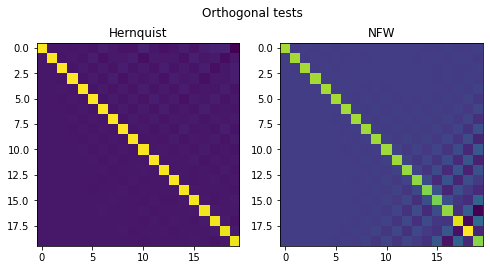

In [27]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(basishern.orthoCheck()[0])
ax[1].imshow(basisNFW.orthoCheck()[0])
ax[0].set_title('Hernquist')
ax[1].set_title('NFW')

fig.suptitle('Orthogonal tests')

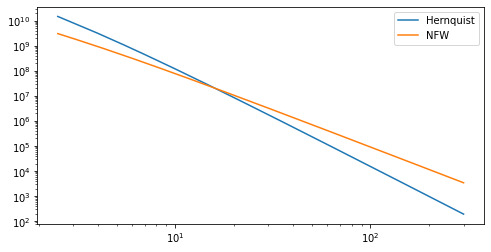

In [21]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

read_model = np.loadtxt('Hernquist_model.txt', skiprows=3)
ax.plot(read_model[:,0],read_model[:,1], label='Hernquist')
ax.set_xscale('log')
ax.set_yscale('log')

read_model = np.loadtxt('NFW_model.txt', skiprows=3)
ax.plot(read_model[:,0],read_model[:,1], label='NFW')

#ax.plot(e_R,e_dens, label='Empirical')

ax.legend()

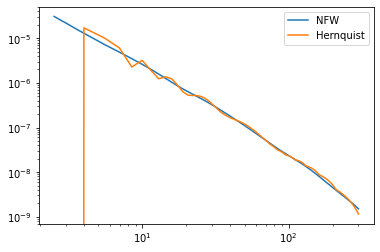

In [23]:
field = 'dens'

rad_NFW, field_NFW = EXPtools.visuals.visualize.spherical_avg_prop(basisNFW,coefsNFW, rmin=2.5, rmax=300, nbins=500, log_space=False, time=0, property=field)
rad_Hern, field_Hern = EXPtools.visuals.visualize.spherical_avg_prop(basishern,coefshern, rmin=2.5, rmax=300, nbins=200, log_space=False, time=0, property=field)
plt.plot(rad_NFW, field_NFW, label='NFW')
plt.plot(rad_Hern, field_Hern, label='Hernquist')
plt.xscale('log')
plt.yscale('log')
plt.legend()

(<Figure size 2000x4200 with 7 Axes>,
 array([<Axes: title={'center': '$\\ell = 0$'}>,
        <Axes: title={'center': '$\\ell = 1$'}>,
        <Axes: title={'center': '$\\ell = 2$'}>,
        <Axes: title={'center': '$\\ell = 3$'}>,
        <Axes: title={'center': '$\\ell = 4$'}>,
        <Axes: title={'center': '$\\ell = 5$'}>,
        <Axes: title={'center': '$\\ell = 6$'}>], dtype=object))

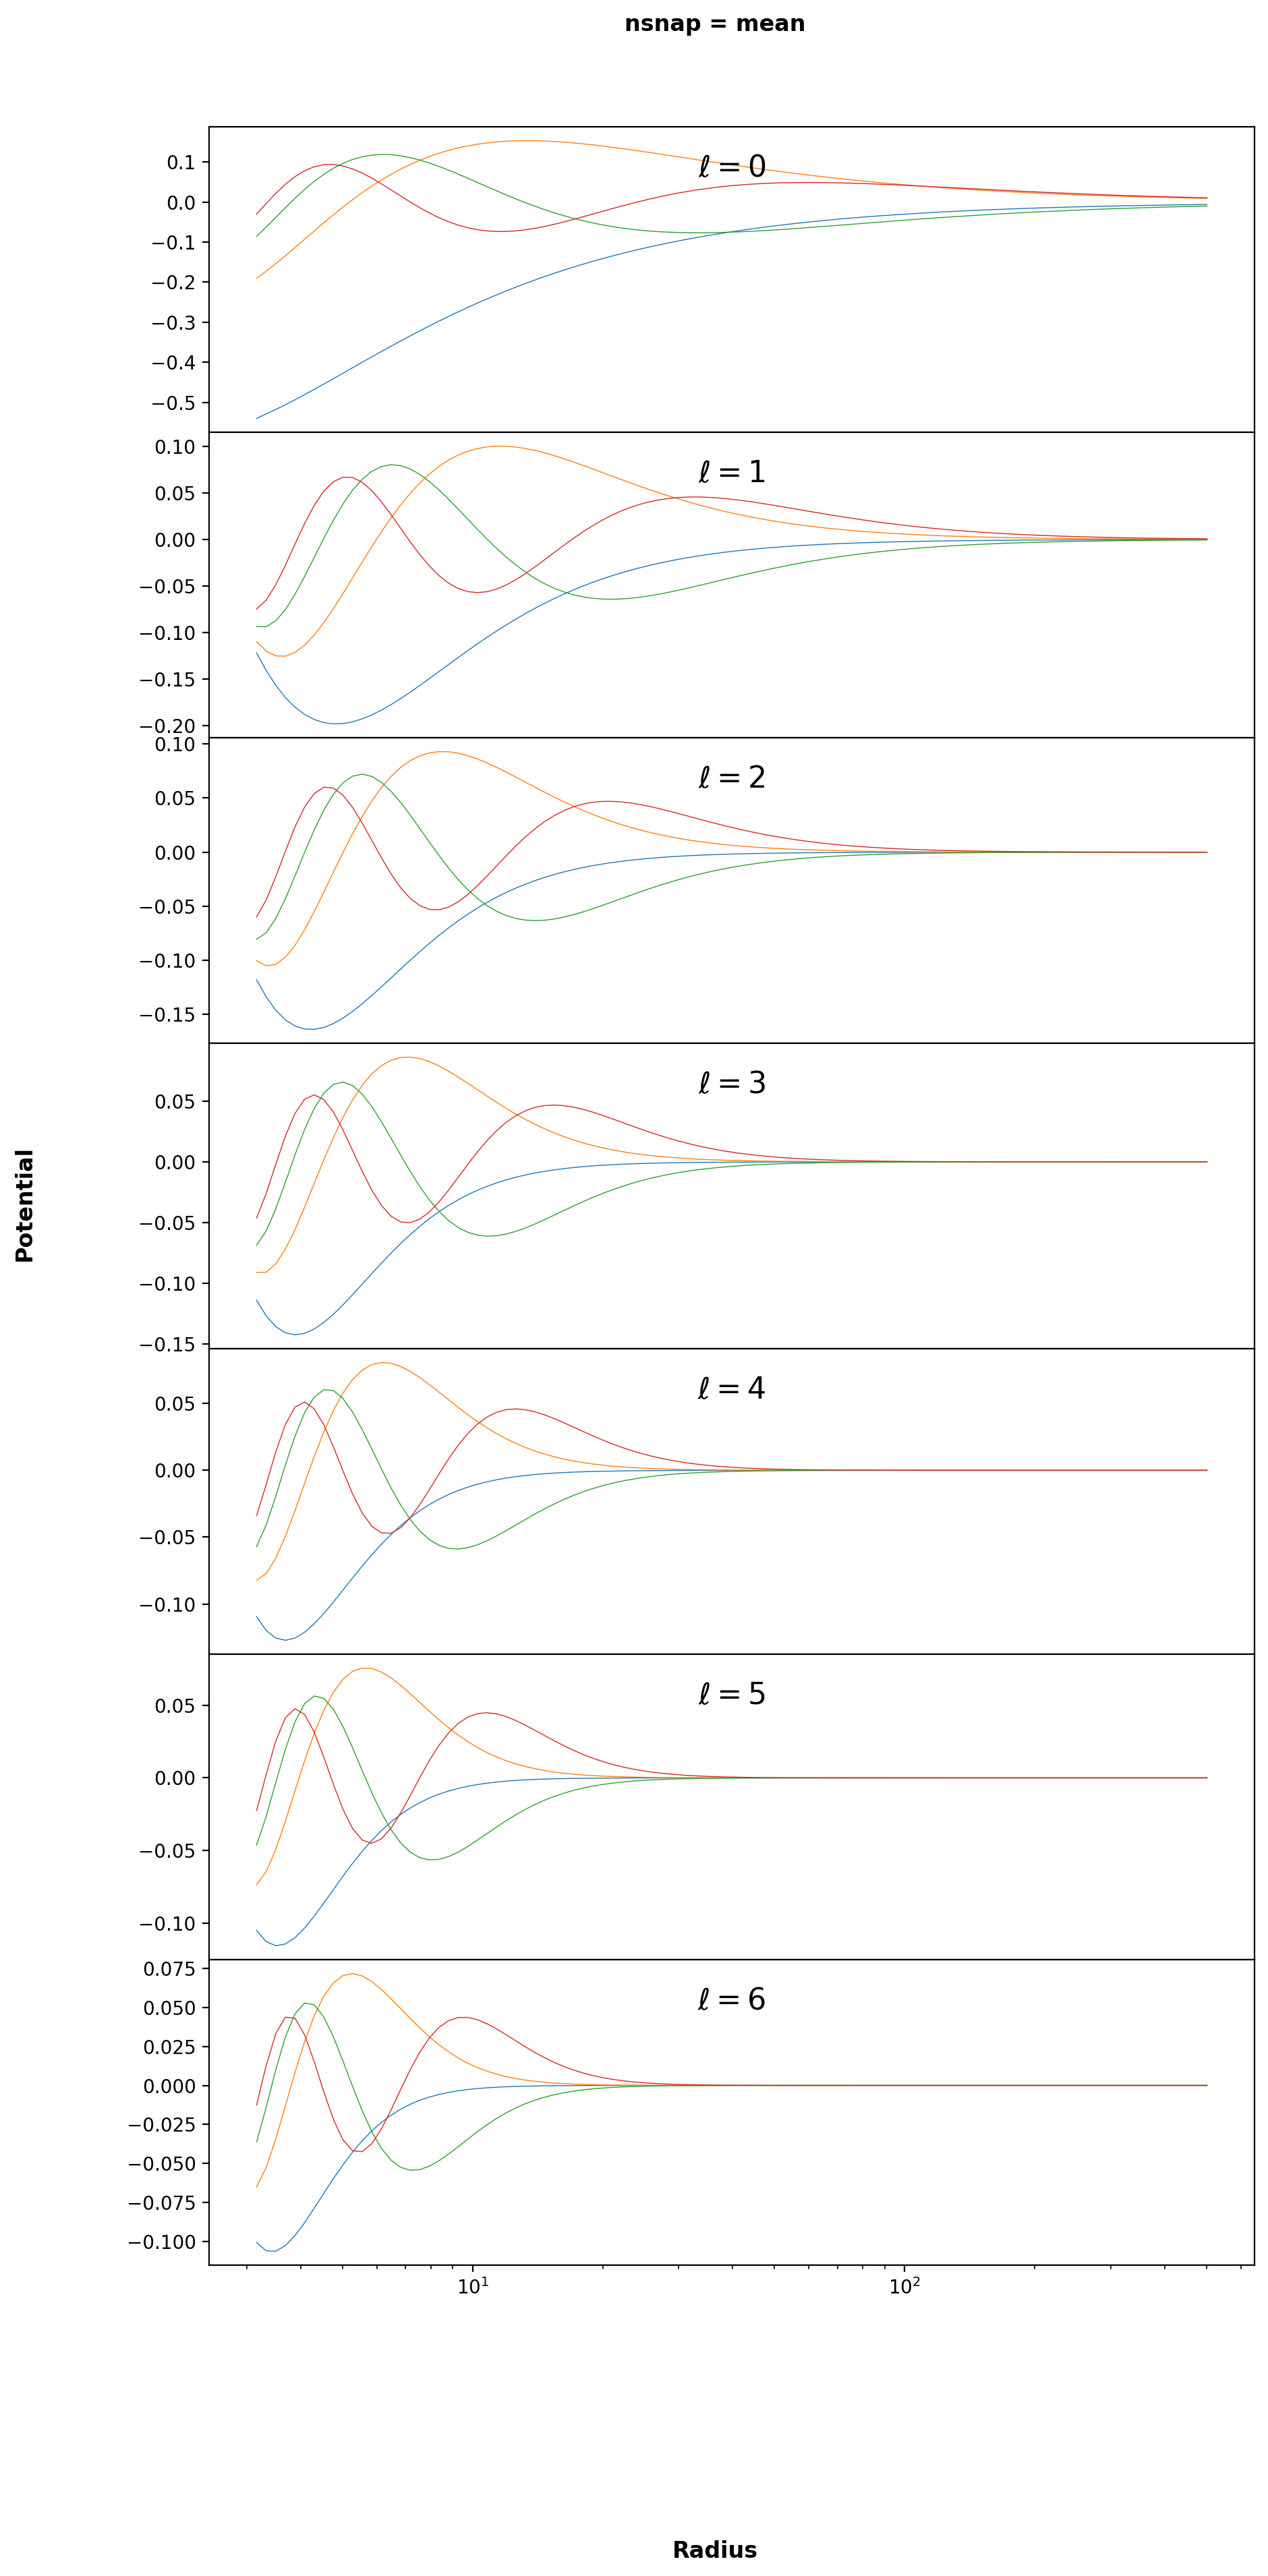

In [14]:
EXPtools.visuals.visualize.make_basis_plot(basishern, lmax=7, nmax=4)

(<Figure size 2000x4200 with 7 Axes>,
 array([<Axes: title={'center': '$\\ell = 0$'}>,
        <Axes: title={'center': '$\\ell = 1$'}>,
        <Axes: title={'center': '$\\ell = 2$'}>,
        <Axes: title={'center': '$\\ell = 3$'}>,
        <Axes: title={'center': '$\\ell = 4$'}>,
        <Axes: title={'center': '$\\ell = 5$'}>,
        <Axes: title={'center': '$\\ell = 6$'}>], dtype=object))

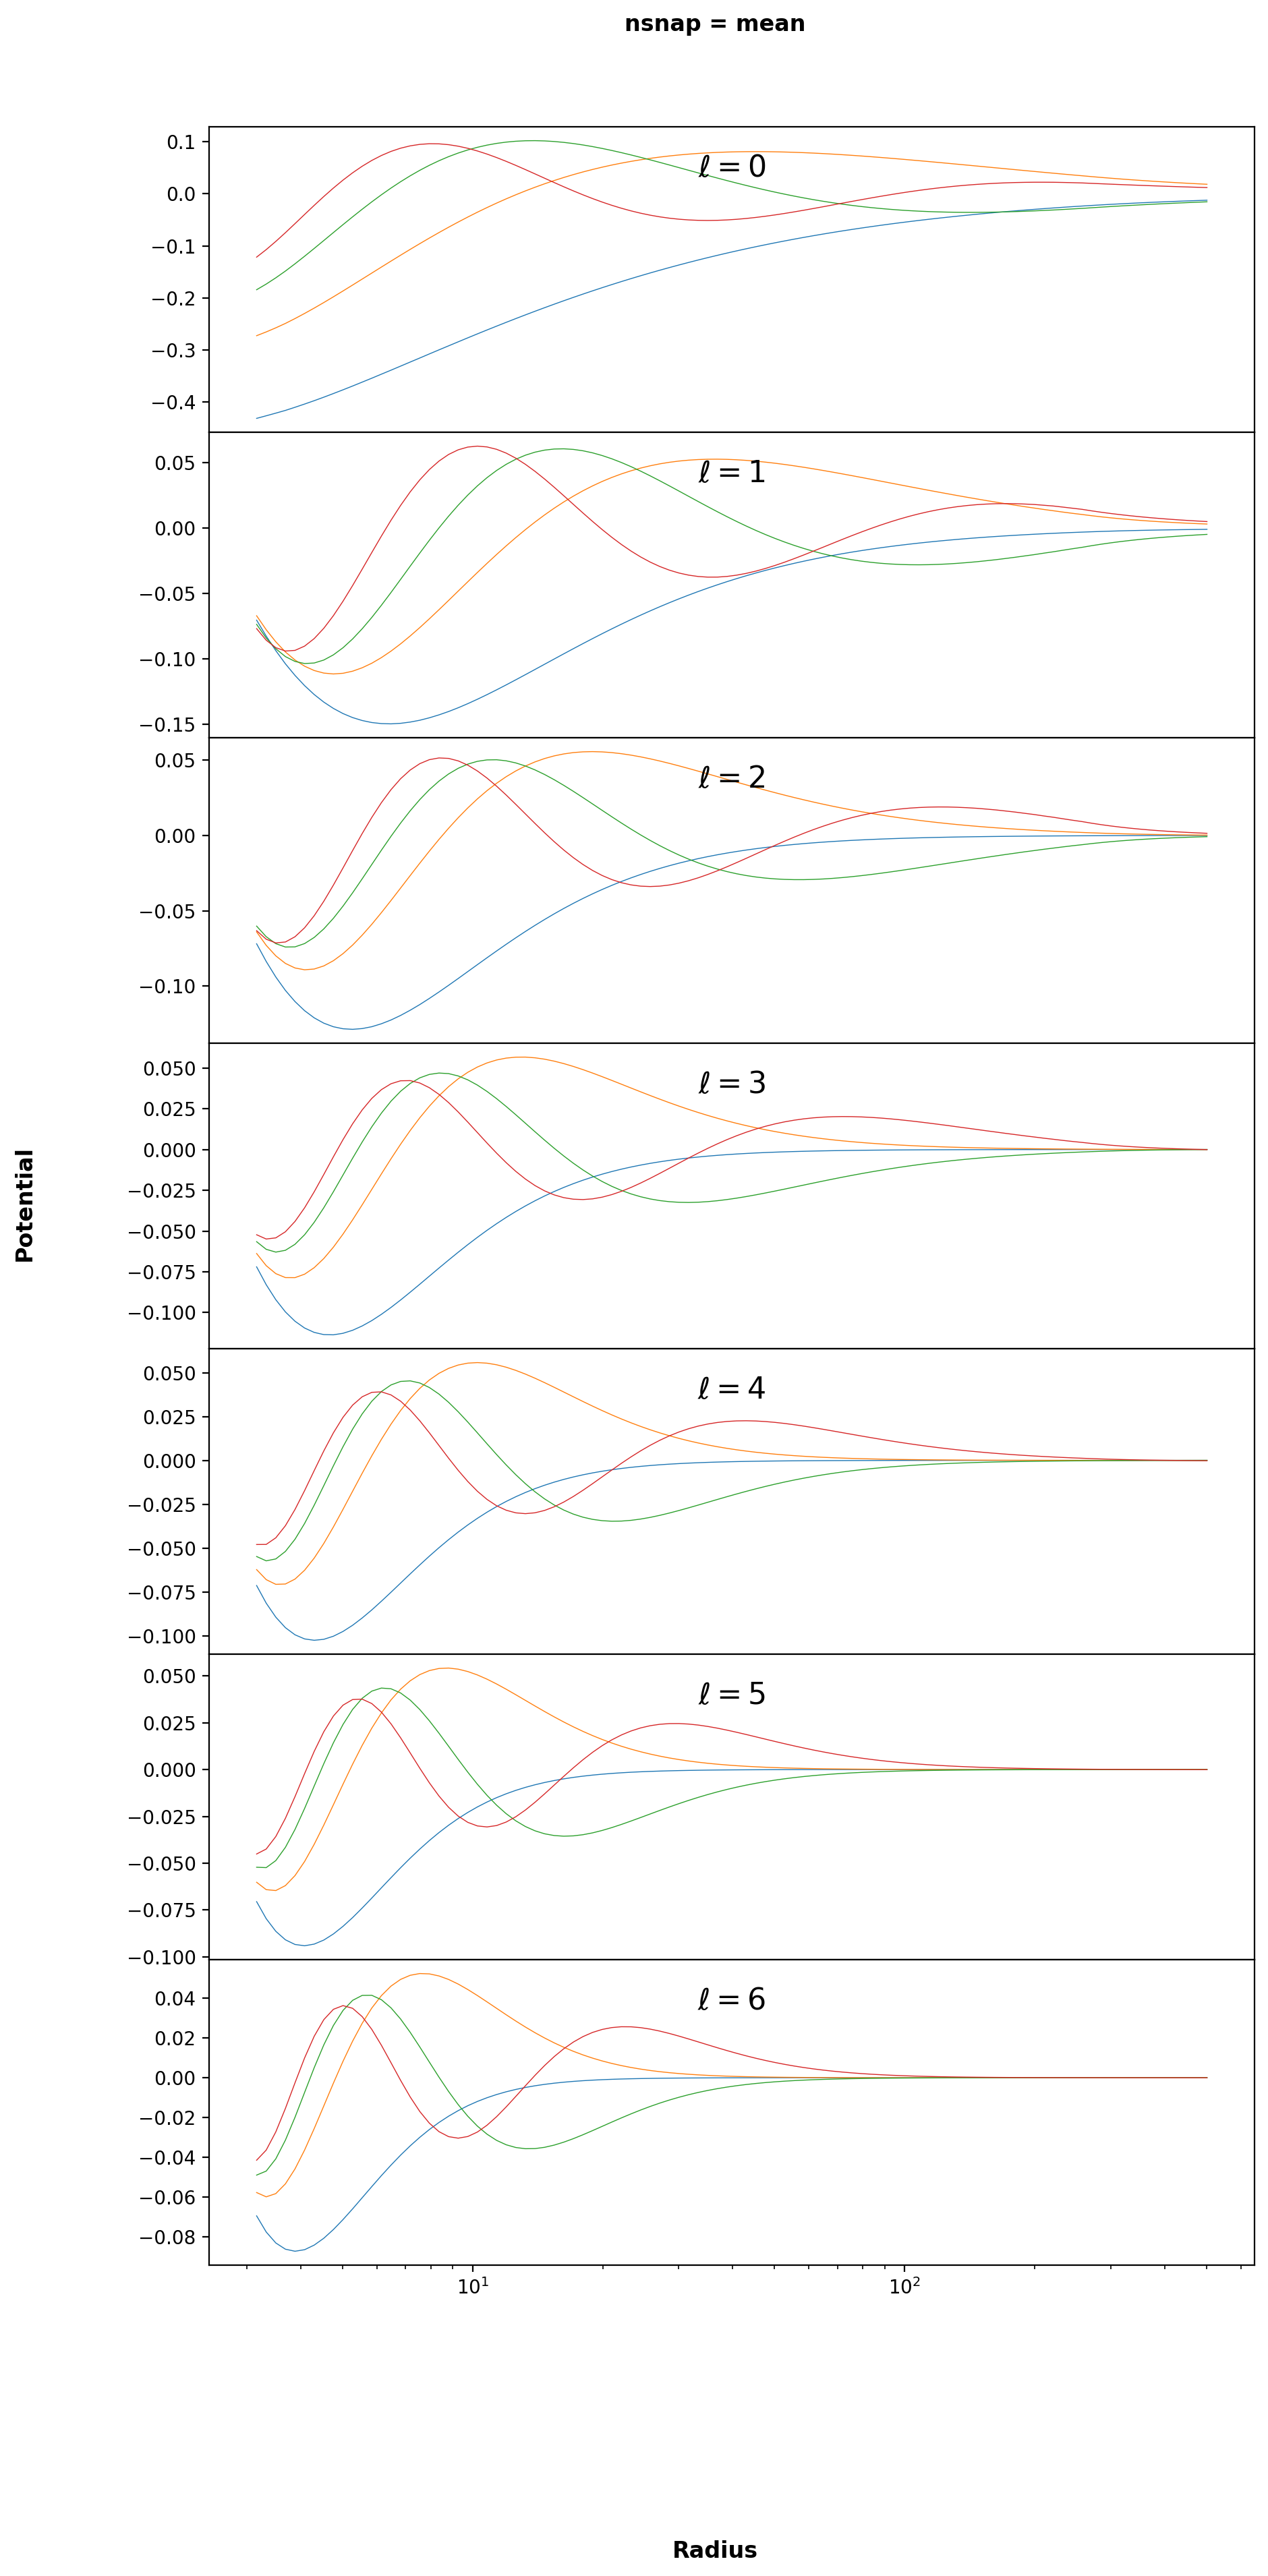

In [15]:
EXPtools.visuals.visualize.make_basis_plot(basisNFW, lmax=7, nmax=4)

In [35]:
EXPtools.visuals.visualize.slice_3d_fields(basisNFW,coefsNFW)

Signature:
EXPtools.visuals.visualize.slice_3d_fields(
    basis,
    coefficients,
    time=0,
    npoints=50,
    grid_limits=(-300, 300),
    prop='dens',
    monopole_only=False,
)
Docstring:
Plots a slice projection of the fields of a simulation.

Args:
basis (obj): object containing the basis functions for the simulation
coefficients (obj): object containing the coefficients for the simulation
time (float): the time at which to plot the fields
npoints (int, optional): the number of grid points in each dimension
grid_limits (tuple, optional): the limits of the grid in the x and y dimensions, in the form (x_min, x_max)
prop (str, optional): the property to return. Can be 'dens' (density), 'pot' (potential), or 'force' (force).
monopole_only (bool, optional): whether to return the monopole component in the returned property value.

Returns:
array or list: the property specified by `prop`. If `prop` is 'force', a list of the x, y, and z components of the force is returned.
          